In [8]:
import random
import time
import requests
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil import tz
import matplotlib.pyplot as plt

In [9]:
def create_tuple(response):
    response_data = response.json()
    response_datum = response_data[0]
    response_target = response_datum['target']
    response_datapoints = response_datum['datapoints']
    tuple_array = [tuple(x) for x in response_datapoints]
    npa = np.array(tuple_array, dtype=[
        ('value', np.double), ('ts', 'datetime64[ms]')])
    return npa

def fume_query(target,server, start,end):
  url = "https://ypsu0n34jc.execute-api.us-east-1.amazonaws.com/dev/query"
  data = {
      "range": {
        "from": start,
        "to": end,
      },
      "targets": [
        {
          "payload": {
            "schema": server,
          },
          "target": target
        }
      ],

    }
  request = requests.post(url, json=data)
  print(request)
  # print(request.json())
  return create_tuple(request)

# fume_query(target="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hood_sash", server="biotech_main", start="2021-12-25T00:00:00.000", end="2021-12-25T00:00:00.000")
# fume_query(target="#biotech_weather/temperature_tn", server="biotech_main", start = str(datetime(2021, 11, 17, 1)), end = str(datetime(2021, 11, 17, 2)))

def query_to_list(point, server, start, end):
    master = fume_query(point, server, start, end)

    list = pd.Series(data=[i[0] for i in master], index=[i[1] for i in master])
    # print("\n", point, "\n", list)

    list = list[~list.index.duplicated()]
    # print("\n", point, " new\n", list)

    return list

In [32]:
def total_time_sash_open(sash_point, occ_point, server, start, end, is_occupied):
  sash_list = query_to_list(sash_point, server, start, end)
  occ_list = query_to_list(occ_point, server, start, end)

  df = pd.concat([sash_list, occ_list], axis=1)
  df.columns = ["sash", "occ"]
  # display(df)

  time_interval = df.index[1].minute - df.index[0].minute
  # print("Time interval", time_interval)

  # Figure out closed sash position
  # display(df["sash"].value_counts())

  # from running the above on a large time difference, 1.2 inches is the most common smallest value
  df["time_open_mins"] = np.where((df["sash"] > 1.2), time_interval, 0)

  df = df.dropna()
  df.index = df.index.map(lambda x: x.to_pydatetime().replace(tzinfo=tz.tzutc()).astimezone(tz.tzlocal()))
  # display(df)

  df = df[df['occ']==int(is_occupied)]

  display(df)
  # plt.plot(df["occ"], df["sash"])

  df = df.groupby(pd.Grouper(freq='60Min', label='right')).sum()

  df.index = df.index.strftime('%s').astype("int")

  display(df)

  print("DF with POSITIVE BAD STUFF!")
  # display(df[df["time_open_mins"] > 0])

  return df["time_open_mins"]

In [34]:
def compute_value(_hood, timestamp):
    """This would be replaced by a real algorithm that computed values 
    based on which hood, the environment, etc..."""
    return [random.random(), timestamp]

sash_data_occ = total_time_sash_open(sash_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hood_sash",
                                occ_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/occ_trend",
                                server="biotech_main",
                                start=str(datetime(2023, 4, 22)),
                                    end=str(datetime.now()),
                                is_occupied=True)

sash_data_unocc = total_time_sash_open(sash_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hood_sash",
                                occ_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/occ_trend",
                                server="biotech_main",
                                start=str(datetime(2023, 4, 22)),
                                    end=str(datetime.now()),
                                is_occupied=False)

# print(sash_data_occ)
# print(sash_data_unocc)

# final_df = pd.DataFrame(data={"occ": sash_data_occ, "unocc" : sash_data_unocc})
# final_df = final_df.fillna(0)
# final_df

# the x-api-key is the secret authentication to allow posting updates
headers = {"x-api-key": "LfSpEZ3woOuljzb2EAg0"}
# the endpoint URL for trend updates
TREND_API_URL = "https://7zhs2wplt9.execute-api.us-east-1.amazonaws.com/dev/trend"
# time in seconds that the request will timeout if no response is received.
# the API will only run for 6 seconds, so if it can't process
# the data posted in that amount of time it will fail.
API_TIMEOUT = 6

# timestamps
now = int(time.time())
last_hour = now - now % 3600
start_time = last_hour - (3600 * 6)

# a list of points
points = [
    # "Biotech.Floor_4.Lab_433.Hood_1.energy.occ",
    # "Biotech.Floor_4.Lab_433.Hood_1.energy.unocc",
    # "Biotech.Floor_4.Lab_433.Hood_1.sashOpenTime.occ",
    "Biotech.Floor_4.Lab_433.Hood_1.sashOpenTime.unocc",
    # "Biotech.GroundFloor.Lab_g54.Hood_1.energy.unocc",
    # "Biotech.GroundFloor.Lab_g54.Hood_1.sashOpenTime.occ",
]

# insert some data and log the results
for point in points:
    # data = [compute_value(point, ts) for ts in range(start_time, last_hour, 3600)]

    data = np.fliplr(sash_data_unocc.reset_index().to_numpy()).tolist()
    print(data)

    json_obj = {"object_name": point, "data": data }
    # e.g.
    # { "object_name": "Biotech.GroundFloor.Lab_g54.Hood_1.energy.occ",
    # "data": [[0, 1681462800], [0, 1681466400], [0, 1681470000], [4.430475, 1681473600]],
    # }
    req_start = time.time()
    response = requests.post(TREND_API_URL, json=json_obj, headers=headers, timeout=API_TIMEOUT)
    req_end = time.time()
    r = response.json()
    print(f"""received status_code:{response.status_code} msg:{r.get('message', None)}
    rows:{r.get('affectedRows', None)} duplicates:{r.get('duplicates', None)} 
    for point:{point} with id:{r.get('obj_id', None)} in {req_end-req_start:.3f} seconds.""")

<Response [200]>
<Response [200]>


,sash,occ,time_open_mins
2023-04-22 13:00:00-04:00,1.2,1.0,0
2023-04-22 13:05:00-04:00,1.2,1.0,0
2023-04-22 13:10:00-04:00,1.2,1.0,0
2023-04-22 13:15:00-04:00,1.2,1.0,0
2023-04-22 13:20:00-04:00,1.2,1.0,0
...,...,...,...
2023-05-02 11:35:00-04:00,1.2,1.0,0
2023-05-02 11:40:00-04:00,1.2,1.0,0
2023-05-02 11:45:00-04:00,1.2,1.0,0
2023-05-02 11:50:00-04:00,1.2,1.0,0


,sash,occ,time_open_mins
1682186400,14.4,12.0,0
1682190000,9.6,8.0,0
1682193600,14.4,12.0,0
1682197200,9.6,8.0,0
1682200800,14.4,12.0,0
...,...,...,...
1683028800,10.8,9.0,0
1683032400,12.0,10.0,0
1683036000,14.4,12.0,0
1683039600,14.4,12.0,0


DF with POSITIVE BAD STUFF!
<Response [200]>
<Response [200]>


,sash,occ,time_open_mins
2023-04-22 00:00:00-04:00,1.2,0.0,0
2023-04-22 00:05:00-04:00,1.2,0.0,0
2023-04-22 00:10:00-04:00,1.2,0.0,0
2023-04-22 00:15:00-04:00,1.2,0.0,0
2023-04-22 00:20:00-04:00,1.2,0.0,0
...,...,...,...
2023-05-02 07:00:00-04:00,1.2,0.0,0
2023-05-02 07:05:00-04:00,1.2,0.0,0
2023-05-02 07:55:00-04:00,1.2,0.0,0
2023-05-02 08:00:00-04:00,1.2,0.0,0


,sash,occ,time_open_mins
1682139600,14.4,0.0,0
1682143200,14.4,0.0,0
1682146800,14.4,0.0,0
1682150400,14.4,0.0,0
1682154000,14.4,0.0,0
...,...,...,...
1683018000,14.4,0.0,0
1683021600,14.4,0.0,0
1683025200,6.0,0.0,0
1683028800,3.6,0.0,0


DF with POSITIVE BAD STUFF!
[[0, 1682139600], [0, 1682143200], [0, 1682146800], [0, 1682150400], [0, 1682154000], [0, 1682157600], [0, 1682161200], [0, 1682164800], [0, 1682168400], [0, 1682172000], [0, 1682175600], [0, 1682179200], [0, 1682182800], [0, 1682186400], [0, 1682190000], [0, 1682193600], [0, 1682197200], [0, 1682200800], [0, 1682204400], [0, 1682208000], [0, 1682211600], [0, 1682215200], [0, 1682218800], [0, 1682222400], [0, 1682226000], [0, 1682229600], [0, 1682233200], [0, 1682236800], [0, 1682240400], [0, 1682244000], [0, 1682247600], [0, 1682251200], [0, 1682254800], [0, 1682258400], [0, 1682262000], [0, 1682265600], [0, 1682269200], [0, 1682272800], [0, 1682276400], [0, 1682280000], [0, 1682283600], [0, 1682287200], [0, 1682290800], [0, 1682294400], [0, 1682298000], [0, 1682301600], [0, 1682305200], [0, 1682308800], [0, 1682312400], [0, 1682316000], [0, 1682319600], [0, 1682323200], [0, 1682326800], [0, 1682330400], [0, 1682334000], [0, 1682337600], [0, 1682341200], [0

<Response [200]>
<Response [200]>


,occ,unocc
2023-04-22 01:00:00-04:00,0.0,0.0
2023-04-22 02:00:00-04:00,0.0,0.0
2023-04-22 03:00:00-04:00,0.0,0.0
2023-04-22 04:00:00-04:00,0.0,0.0
2023-04-22 05:00:00-04:00,0.0,0.0
...,...,...
2023-05-02 10:00:00-04:00,0.0,0.0
2023-05-02 11:00:00-04:00,0.0,0.0
2023-05-02 12:00:00-04:00,0.0,0.0
2023-05-02 13:00:00-04:00,0.0,0.0


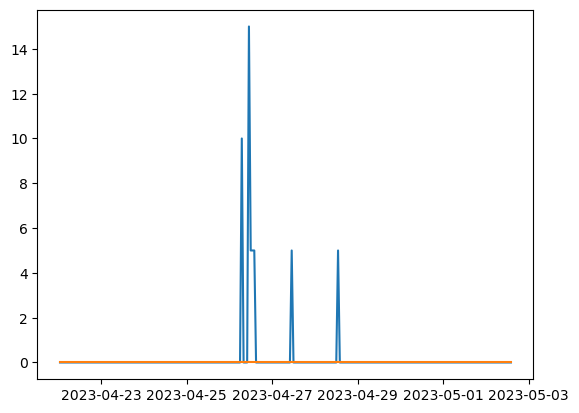

In [36]:
def synthetic_query(target, start, end):
    url = "https://portal.emcs.cornell.edu/api/datasources/proxy/5/query"
    data = {
        "range": {
            "from": start,
            "to": end,
        },
        "targets": [
            {
                "target": target
            }
        ],

    }
    request = requests.post(url, json=data)
    print(request)
    # print(request.json())
    master = create_tuple(request)
    list = pd.Series(data=[i[0] for i in master],
                     index=[i[1] for i in master])

    list = list[~list.index.duplicated()]

    return list

sash_data_occ = synthetic_query(target="Biotech.Floor_4.Lab_433.Hood_1.sashOpenTime.occ",
                                    start=str(datetime(2023, 4, 22)),
                                    end=str(datetime.now()))

sash_data_unocc = synthetic_query(target="Biotech.Floor_4.Lab_433.Hood_1.sashOpenTime.unocc",
                                      start=str(datetime(2023, 4, 22)),
                                      end=str(datetime.now()))

final_df = pd.DataFrame(
        data={"occ": sash_data_occ, "unocc": sash_data_unocc})
final_df = final_df.fillna(0)
final_df.index = final_df.index.map(lambda x: x.to_pydatetime().replace(tzinfo=tz.tzutc()).astimezone(tz.tzlocal()))
display(final_df)
plt.plot(final_df)